In [18]:
import src
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings
# Pandas will give a lot of warning while I am mutating data frames in functions.
filterwarnings('ignore')
# Matplot lib inline
plt.style.use('seaborn')
sns.set_style("whitegrid")
%matplotlib inline

In [26]:
# import the cleaned data as described in /datacleaning/genrecleaning.ipynb
df1  = pd.read_csv('rawdata/genres-budget.csv')
df2 = pd.read_csv('rawdata/genre-month-roi.csv')
df_titles = pd.read_csv('rawdata/title.csv')

In [27]:
df1.head()

,tconst,genres,numvotes,averagerating,start_year,runtime_minutes,Adult,Sport,Sci-Fi,Fantasy,...,Comedy,Action,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,roi
0,tt0249516,"Action,Animation,Comedy",8248,1.9,2012,91.0,False,False,False,False,...,True,True,2012-12-31,foodfight!,45000000.0,$0,73706.0,2012,12,-99.836209
1,tt0337692,"Adventure,Drama,Romance",37886,6.1,2012,124.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
2,tt4339118,Drama,6,6.0,2014,89.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
3,tt5647250,Drama,127,5.7,2016,121.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
4,tt0359950,"Adventure,Comedy,Drama",275300,7.3,2013,114.0,False,False,False,False,...,True,False,2013-12-25,the secret life of walter mitty,91000000.0,"$58,236,838",187861183.0,2013,12,106.440860


### Explanation of the table
We wrangled this data from data sets scraped from imdb and  includes a truth matrix for all the genres to allow simple indexing as well as metadata pertaining the movies overall success.

We removed all observations with missing values for genre, worldwide_gross and production_budget as these values are critical to our hyptotheses. In addition, no observations from before 2010 and after 2019 were included in the data set. This was to insure the relevance of the data to the business question at hand.

## Genre Analysis
Our hypothesis was that genre played a large role in the ratings and success of a movie. To test this we created a custom function to examine the average return on investment (roi) and total international gross revenue.

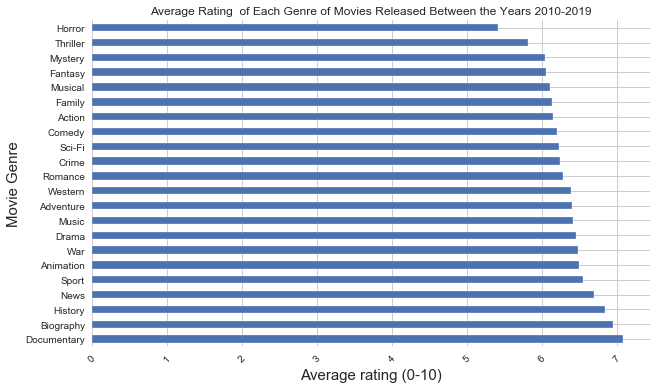

In [40]:
# src function and documentation available in src.py
df1.genres = src.coerce_to_list(df1, 'genres')
df_to_plot = src.genre_pandas_mean(df1, 'averagerating')
df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Average Rating  of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('Average rating (0-10)', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

#### Genre doesn't have a large impact on rating

This is no surprising, movies from any genre can perform well. So we asked how well do movies perform as a function of their production budget.

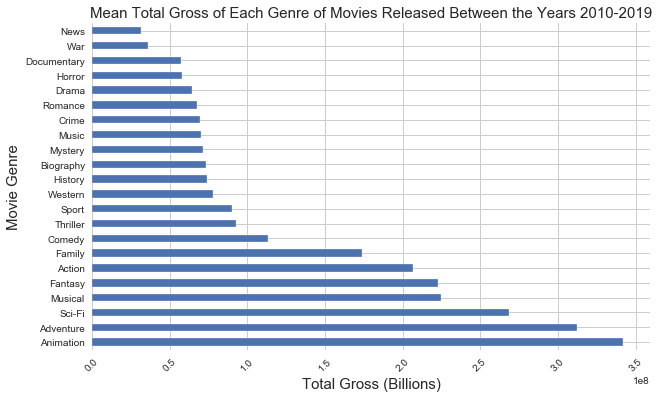

In [41]:
df_to_plot = src.genre_pandas_mean(df1, 'worldwide_gross')
df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean Total Gross of Each Genre of Movies Released Between the Years 2010-2019', size=15)
plt.xlabel('Total Gross (Billions)', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

#### Animation, Adventure, Sci-Fi have dominated over the past 10 years

Big production budgets on superhero movies have skewed this data. It would be interesting to look into the performance of superhero movies and franchises. Future research should look into that relationship.

However, total gross income from a movie isn't the fairest indicator of success. When we normalize the data by production budget to get the return on investment, a different story emerges.

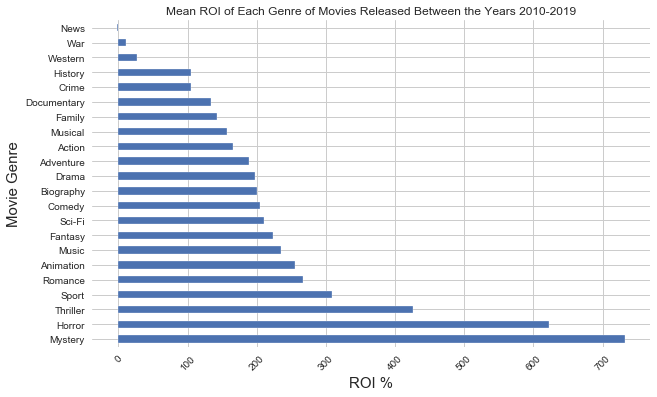

In [42]:
# See src.genre_pandas_mean in src documentation
df_to_plot = src.genre_pandas_mean(df1, 'roi')

df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))


plt.xticks(rotation = 45)
plt.title('Mean ROI of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15)
plt.savefig('roi_genre.png');

#### So people seem to have a morbid curiousity
When we look at the ROI, the top genres are now replaced by Mystery, Horror and Thrillers. Almost 40% of movies made contain one of these horror tags. So, not only are they good value for money but they seem to be relatively simply to make. Further research should be done on the production costs, both financial and time of producing these movies.


However, this analysis includes duplicate values in the means. So this begs the question, is there some magical combination of genres that leads to high return on investment?

In [49]:
thriller = len(df1[df1.Thriller==True])/len(df1)
horror = len(df1[df1.Horror==True])/len(df1)
mystery = len(df1[df1.Mystery==True])/len(df1)

print((thriller+horror+mystery)* 100)

38.301636444051304


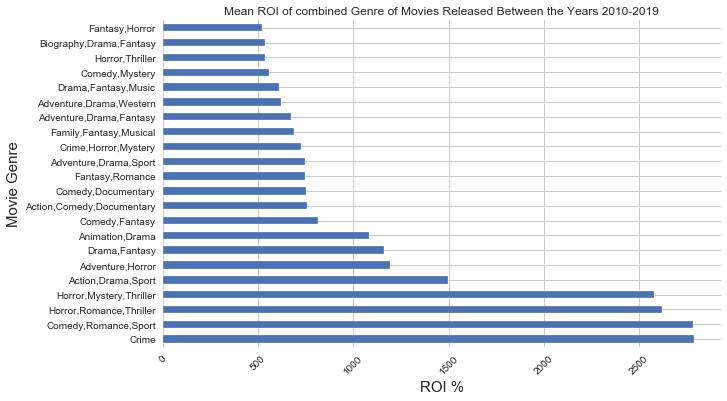

In [50]:
# Reload the database to reset the genre column from list back to string
df1 = pd.read_csv('rawdata/genres-budget.csv')

# Group the values by genre (combinations present this time) and check ROI for the top 22 genres
grouped = df1.groupby(['genres']).roi.mean().sort_values(ascending=False)[:22]

# Create chart based on the data
# See src.genre_pandas_mean in src documentation
grouped.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean ROI of combined Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15)
plt.savefig('roi_genre.png');

#### So as it happens, crime does pay!

Or atleast people are willing to spend a signeficant amount of money to watch it. 

And as we expected, Horror, Mystery and Thriller are all featured in top 5. But interestingly, they do not take the top spot over all.

What is the highest ROI crime movie of all time?

In [51]:
highest_crime = df1.sort_values('roi', ascending = False)[df1.Crime == True].iloc[0,:1].values[0]
df_titles[df_titles.tconst == highest_crime]

,primary_title,tconst
1734,split,tt3604256


Split is more of a mystery/crime/thriller if you ask us. Which brings me to a key point about this analysis, The categorization by genre is subjective and therefore taken alone is not firm evidence for the success of one genre over another. 

The trend is that horror movies, thrillers and crime movies generate a great return on investment. But, does is matter how much money you invest initially? It there a point of dimninishing returns for your investment?

Using the same categorization method from the above section we used a categorization plot to directly compare budget categoy and ROI. I produced this dataframe in the `datacleaning` note book. We chose to include duplicates for each genre. Though this amplifies the effect of outliers, It also let's us examine indiviual genre performance.

In [36]:
df2.head()

,tconst,genre,roi,month,production_category
0,tt4283448,Sport,447.422252,6,large
1,tt0453562,Sport,214.421616,4,medium
2,tt0964517,Sport,1075.112618,12,medium
3,tt1130964,Sport,-93.197350,3,medium
4,tt1210166,Sport,122.601670,9,medium


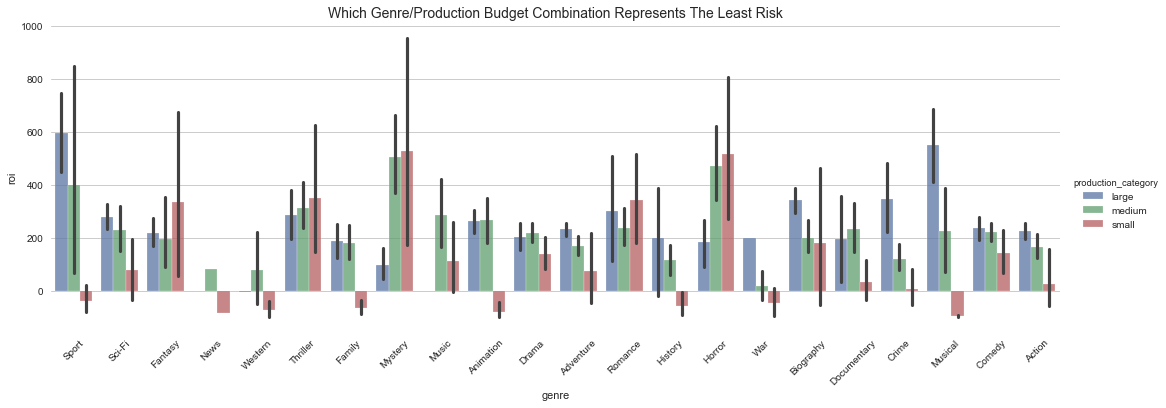

In [39]:
# Categorical plot examining the effect of genre on ROI
sns.catplot(x = 'genre',
            y = 'roi',
            hue = 'production_category', 
            data = df2,
            kind = 'bar',
            height = 5,
            aspect =3, alpha=0.75);
plt.xticks(rotation = 45)
plt.title("Which Genre/Production Budget Combination Represents The Least Risk", size = 14);
plt.legend()

The relative size of each group makes it difficult to interpret the data. However, it is clear that depending on genre of movie, budget considerations are very important. For example, musicals perform very well when the budget is hight, but if the budget is too low, you run the risk of losing a lot of money. 

#### Conclusion from Genre Analysis
We reccomend high budget (>100 million) Sport movies and Musicals, medium budget (between 5 million and 100 milion) mysteries, and low budget (< 5 million) Horror movies.

## Time Series: When to Release?

Up until this point we have looked exlusively at static features. Here, we attempt to interpret the value of releasing at certain times. 

The for this, we first looked into both the number of releases per month and the 